# Strain mapping with py4DSTEM

The code in this directory calculates and visualizes strain maps.

The procedure is divided into 7 steps, each in a single notebook:
1. Get probe template
2. Get the Bragg disks
3. **Determine the diffraction shifts**
4. Calculate lattice vectors
5. Refine lattice vectors
6. Calculate strain
7. Visualize strain maps

# Notebook 3: Determine the diffraction shifts

In this step the relative shifts of the diffraction patterns due to the scanning of the beam are calculated, as follows:

* Find unscattered beam positions
    * Get initial guess at unscattered beam position: calculating average deconvolution, take its center of mass
    * Get unscattered beam position in each DP, two ways:
        * (1) Closest disk to the initial guess
        * (2) Highest intensity peak in cross correlation
    * Identify DPs in which methods (1) and (2) agree
* Fit diffraction shifts
    * Fit a plane (or low order polynomial) to calculated diffration shifts, using only DPs where methods (1) and (2) agreed
* Apply shifts and save
    * Apply shifts to Bragg peak list
    * Calculate shift-corrected deconvolution, confirming peaks collapse to Delta functions
    * Save shifts
    * Save shift-corrected Bragg peak list
    * (Optional) Save deconvolution
* (Optional) Create shift-corrected 4D datacube

### Import packages, load data

In [1]:
import py4DSTEM

import numpy as np
import matplotlib.pyplot as plt
from time import time
from scipy.ndimage.filters import gaussian_filter

from py4DSTEM.file.datastructure import DiffractionSlice, RealSlice
from py4DSTEM.file.readwrite import FileBrowser, read, append

In [2]:
# Examine file contents

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
browser = FileBrowser(fp)
browser.show_dataobjects()

 Index                  Name                        Type        
   0    datacube                            DataCube            
   1    deconvolution                       DiffractionSlice    
   2    probe_kernel                        DiffractionSlice    
   3    DF_image                            RealSlice           
   4    realslice_0                         RealSlice           
   5    strain_maps                         RealSlice           
   6    uv_map                              RealSlice           
   7    lattice_vectors                     PointList           
   8    Braggpeaks                          PointListArray      
   9    Braggpeaks_2                        PointListArray      
   10   shifted_Braggpeaks                  PointListArray      


In [3]:
# Load data

dc = browser.get_dataobject('datacube')
Braggpeak_pointlistarray = browser.get_dataobject('Braggpeaks')
browser.close()

### Find unscattered beam positions

In [4]:
# Get the average deconvolution

average_deconvolution = DiffractionSlice(data=np.zeros((dc.Q_Nx,dc.Q_Ny)))

for Rx in range(Braggpeak_pointlistarray.shape[0]):
    for Ry in range(Braggpeak_pointlistarray.shape[1]):
        pointlist = Braggpeak_pointlistarray.get_pointlist(Rx,Ry)
        for k in range(pointlist.length):
            qx = int(pointlist.data['qx'][k])
            qy = int(pointlist.data['qy'][k])
            average_deconvolution.data2D[qx,qy] += pointlist.data['intensity'][k]

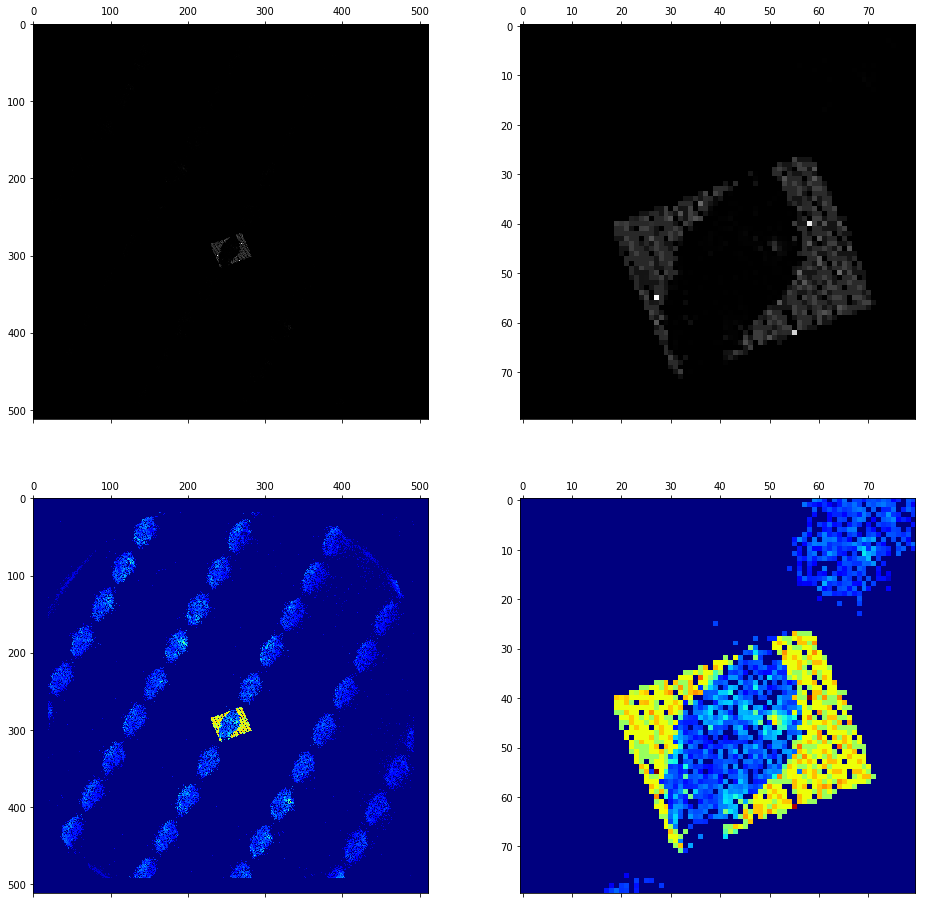

In [5]:
# Plot

x0,y0=py4DSTEM.process.utils.get_CoM(average_deconvolution.data2D)
x0,y0=int(x0),int(y0)
rad=40

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(average_deconvolution.data2D)
ax12.matshow(average_deconvolution.data2D[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(average_deconvolution.data2D**0.25,cmap='jet')
ax22.matshow(average_deconvolution.data2D[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

In [6]:
# Get average central beam position, from CoM of average deconvolution

central_beam_qx0, central_beam_qy0 = py4DSTEM.process.utils.get_CoM(average_deconvolution.data2D)

In [7]:
# Get the diffraction shifts for each DP. Use two methods:
# (1) closest peak to CoM of average deconvolution, and
# (2) brightest cross correlation peak

diffraction_shifts_intensity = RealSlice(data=np.empty((dc.R_Nx,dc.R_Ny,2)), slicelabels=('x','y'))
diffraction_shifts_position = RealSlice(data=np.empty((dc.R_Nx,dc.R_Ny,2)), slicelabels=('x','y'))

for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        Rij_point_list = Braggpeak_pointlistarray.get_pointlist(Rx,Ry)
        
        index = np.argmax(Rij_point_list.data['intensity'])
        diffraction_shifts_intensity.data2D['x'][Rx,Ry] = Rij_point_list.data['qx'][index]
        diffraction_shifts_intensity.data2D['y'][Rx,Ry] = Rij_point_list.data['qy'][index]
        
        r2 = (Rij_point_list.data['qx']-central_beam_qx0)**2 + (Rij_point_list.data['qy']-central_beam_qy0)**2
        index = np.argmin(r2)
        diffraction_shifts_position.data2D['x'][Rx,Ry] = Rij_point_list.data['qx'][index]
        diffraction_shifts_position.data2D['y'][Rx,Ry] = Rij_point_list.data['qy'][index]

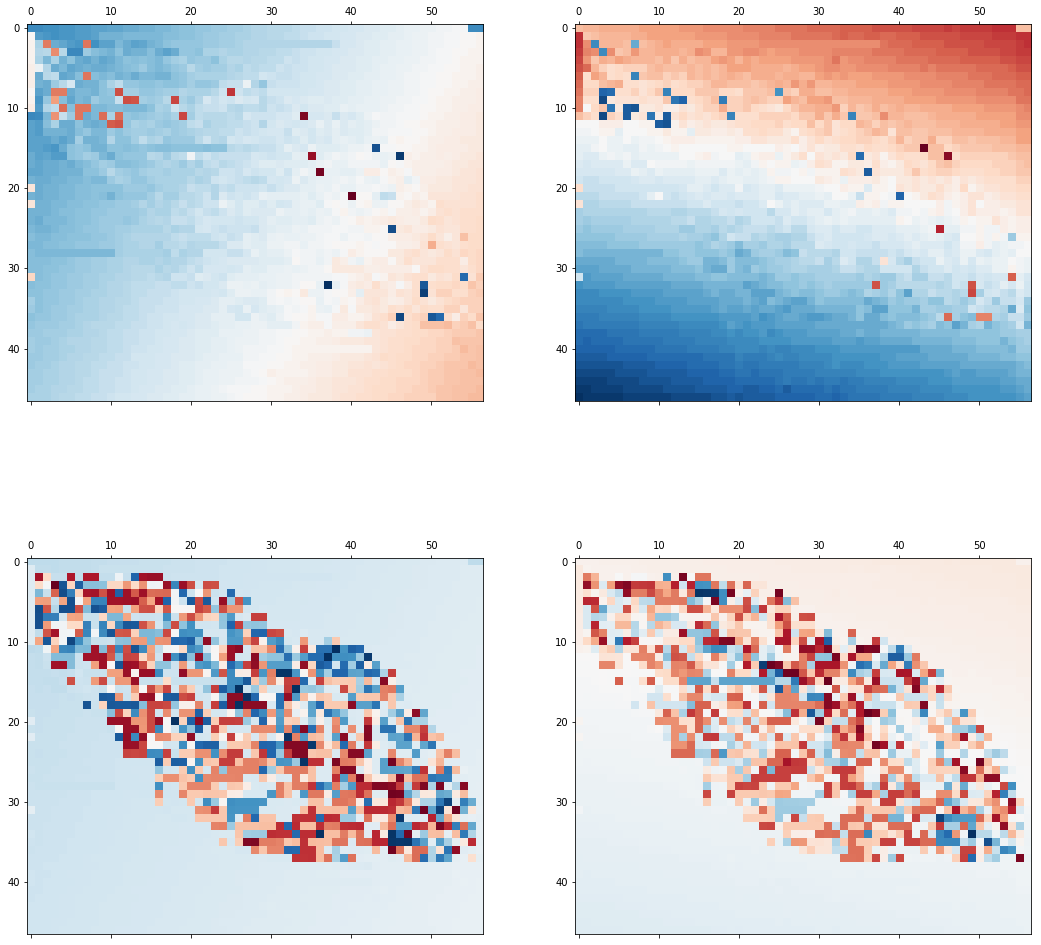

In [8]:
# Plot shifts

fig,((ax11,ax12),(ax21,ax22)) = plt.subplots(2,2,figsize=(18,18))
ax11.matshow(diffraction_shifts_position.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_position.data2D['y'],cmap="RdBu")
ax21.matshow(diffraction_shifts_intensity.data2D['x'],cmap="RdBu")
ax22.matshow(diffraction_shifts_intensity.data2D['y'],cmap="RdBu")
plt.show()

In [9]:
# Identify probe positions where Bragg peak identified as central disk agrees using either method of identification
# Create mask corresponding to where we are most confident the central peak has been correctly determined

diffraction_shifts = RealSlice(data=np.zeros((dc.R_Nx,dc.R_Ny,3)),
                               slicelabels=('x','y','known_mask'))
diffraction_shifts.data2D['known_mask'] = diffraction_shifts.data2D['known_mask'].astype(bool)

for Rx in range(dc.R_Nx):
    for Ry in range(dc.R_Ny):
        Rij_point_list = Braggpeak_pointlistarray.get_pointlist(Rx,Ry)
        
        r2 = (Rij_point_list.data['qx']-central_beam_qx0)**2 + (Rij_point_list.data['qy']-central_beam_qy0)**2
        index1 = np.argmin(r2)
        index2 = np.argmax(Rij_point_list.data['intensity'])
        
        if index1 == index2:
            diffraction_shifts.data2D['x'][Rx,Ry] = Rij_point_list.data['qx'][index1]
            diffraction_shifts.data2D['y'][Rx,Ry] = Rij_point_list.data['qy'][index1]
            diffraction_shifts.data2D['known_mask'][Rx,Ry] = True

In [10]:
# Subtract off average from diffraction shifts

diffraction_shifts.data2D['x']=diffraction_shifts.data2D['x']-np.average(diffraction_shifts.data2D['x'][diffraction_shifts.data2D['known_mask']])
diffraction_shifts.data2D['y']=diffraction_shifts.data2D['y']-np.average(diffraction_shifts.data2D['y'][diffraction_shifts.data2D['known_mask']])

diffraction_shifts.data2D['x'][diffraction_shifts.data2D['known_mask']==False] = 0
diffraction_shifts.data2D['y'][diffraction_shifts.data2D['known_mask']==False] = 0

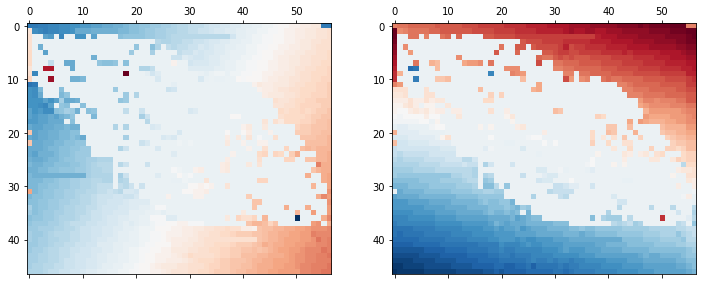

In [11]:
# Plot known shifts

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,18))
ax1.matshow(diffraction_shifts.data2D['x'],cmap="RdBu")
ax2.matshow(diffraction_shifts.data2D['y'],cmap="RdBu")
plt.show()

### Fit diffraction shifts

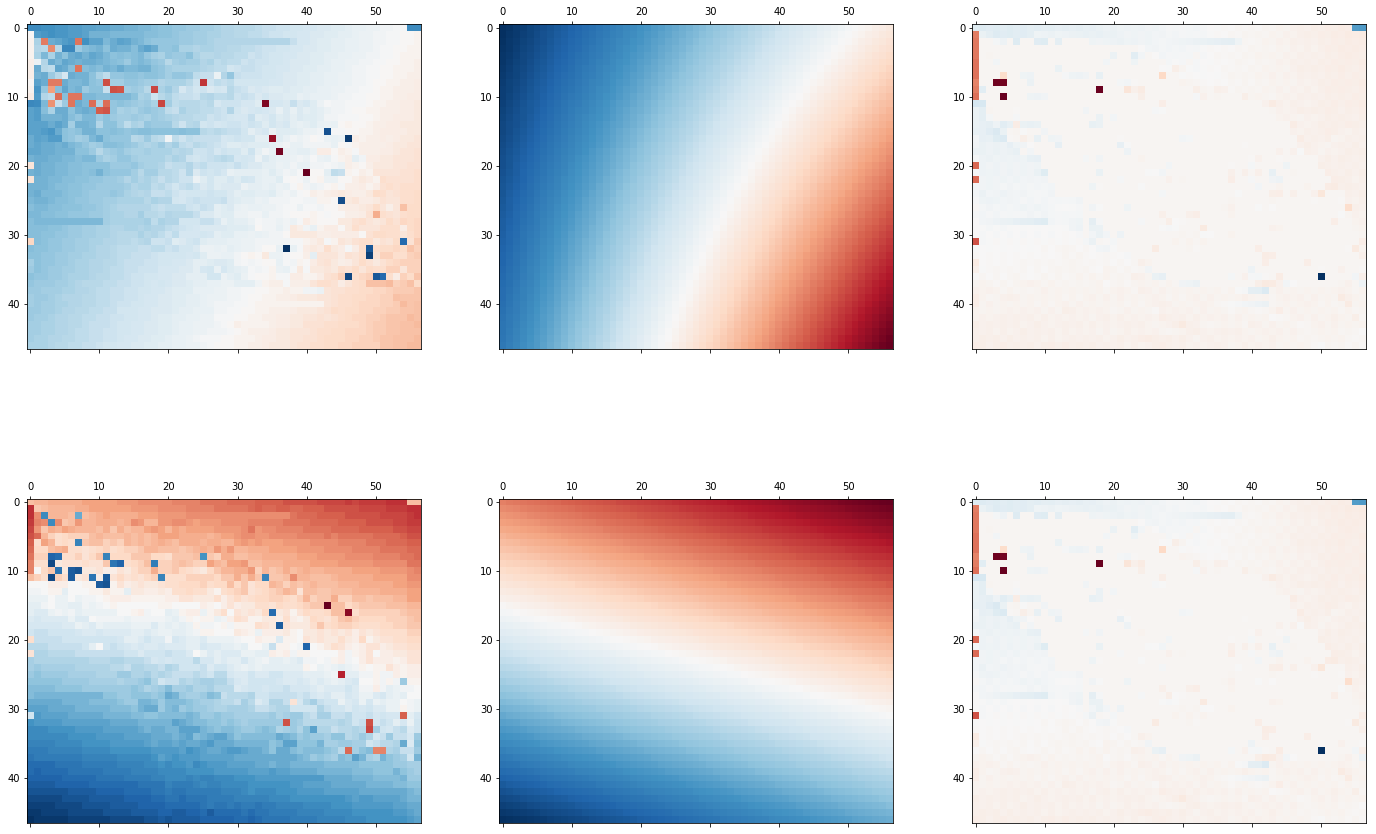

In [12]:
# Fit with diffraction shifts determined by positions (method 1)

fit_function = py4DSTEM.process.fit.parabola

diffraction_shifts_fit_all = RealSlice(data=np.zeros((dc.R_Nx,dc.R_Ny,2)), slicelabels=('x','y'))

popt_x, pcov_x, diffraction_shifts_fit_all.data2D['x'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts_position.data2D['x'])
popt_y, pcov_y, diffraction_shifts_fit_all.data2D['y'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts_position.data2D['y'])

residuals_x = diffraction_shifts_position.data2D['x']-diffraction_shifts_fit_all.data2D['x']
residuals_x[diffraction_shifts.data2D['known_mask']==False] = 0
residuals_y = diffraction_shifts_position.data2D['x']-diffraction_shifts_fit_all.data2D['x']
residuals_y[diffraction_shifts.data2D['known_mask']==False] = 0

fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,16))
ax11.matshow(diffraction_shifts_position.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_fit_all.data2D['x'],cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu")
ax21.matshow(diffraction_shifts_position.data2D['y'],cmap="RdBu")
ax22.matshow(diffraction_shifts_fit_all.data2D['y'],cmap="RdBu")
ax23.matshow(residuals_y,cmap="RdBu")
plt.show()

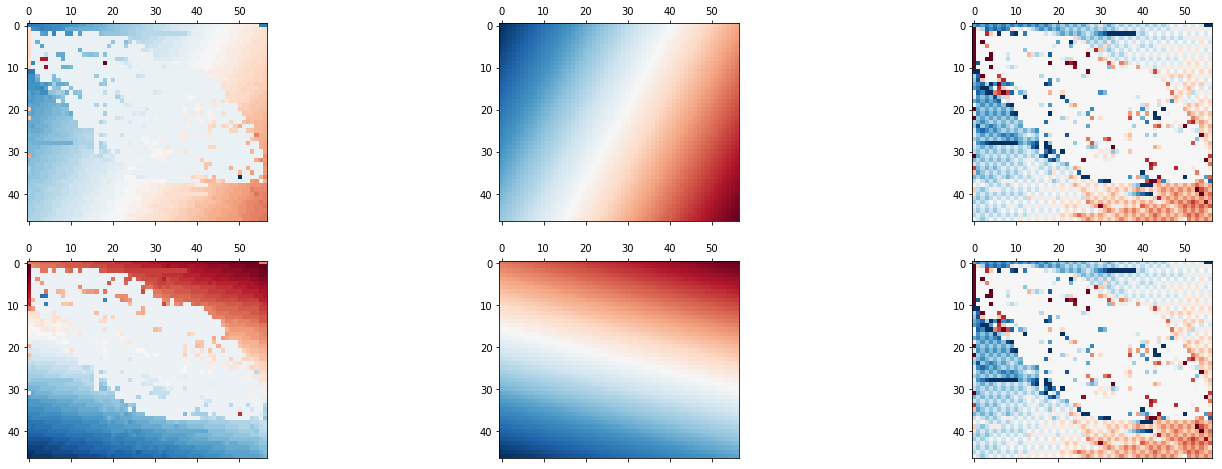

In [13]:
# Fit with only datapoints where diffraction_shifts_known==True

fit_function = py4DSTEM.process.fit.plane

diffraction_shifts_fit = RealSlice(data=np.zeros((dc.R_Nx,dc.R_Ny,2)),
                                   slicelabels=('x','y'), name='diffraction_shifts')

popt_x, pcov_x, diffraction_shifts_fit.data2D['x'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['x'], data_mask=diffraction_shifts.data2D['known_mask'])
popt_y, pcov_y, diffraction_shifts_fit.data2D['y'] = py4DSTEM.process.fit.fit_2D(fit_function, diffraction_shifts.data2D['y'], data_mask=diffraction_shifts.data2D['known_mask'])

residuals_x = diffraction_shifts.data2D['x']-diffraction_shifts_fit.data2D['x']
residuals_x[diffraction_shifts.data2D['known_mask']==False] = 0
residuals_y = diffraction_shifts.data2D['x']-diffraction_shifts_fit.data2D['x']
residuals_y[diffraction_shifts.data2D['known_mask']==False] = 0

fig,((ax11,ax12,ax13),(ax21,ax22,ax23))=plt.subplots(2,3,figsize=(24,8))
ax11.matshow(diffraction_shifts.data2D['x'],cmap="RdBu")
ax12.matshow(diffraction_shifts_fit.data2D['x'],cmap="RdBu")
ax13.matshow(residuals_x,cmap="RdBu",vmin=np.median(residuals_x)-np.std(residuals_x),vmax=np.median(residuals_x)+np.std(residuals_x))
ax21.matshow(diffraction_shifts.data2D['y'],cmap="RdBu")
ax22.matshow(diffraction_shifts_fit.data2D['y'],cmap="RdBu")
ax23.matshow(residuals_y,cmap="RdBu",vmin=np.median(residuals_y)-np.std(residuals_y),vmax=np.median(residuals_y)+np.std(residuals_y))
plt.show()

### Apply shifts, calculate shift-corrected deconvolution

In [14]:
# Apply shifts to Bragg peak list

shifted_Braggpeak_pointlistarray = Braggpeak_pointlistarray.copy(name="shifted_Braggpeaks")

for Rx in range(shifted_Braggpeak_pointlistarray.shape[0]):
    for Ry in range(shifted_Braggpeak_pointlistarray.shape[1]):
        pointlist = shifted_Braggpeak_pointlistarray.get_pointlist(Rx,Ry)
        for k in range(pointlist.length):
            shift_qx = int(diffraction_shifts_fit.data2D['x'][Rx,Ry])
            shift_qy = int(diffraction_shifts_fit.data2D['y'][Rx,Ry])
            pointlist.data['qx'][k] = pointlist.data['qx'][k] - shift_qx
            pointlist.data['qy'][k] = pointlist.data['qy'][k] - shift_qy

In [15]:
# Calculate average deconvolution

deconvolution = DiffractionSlice(data=np.zeros((dc.Q_Nx,dc.Q_Ny)), name='deconvolution')

for Rx in range(shifted_Braggpeak_pointlistarray.shape[0]):
    for Ry in range(shifted_Braggpeak_pointlistarray.shape[1]):
        pointlist = shifted_Braggpeak_pointlistarray.get_pointlist(Rx,Ry)
        for k in range(pointlist.length):
            qx = int(pointlist.data['qx'][k])
            qy = int(pointlist.data['qy'][k])
            if (qx<dc.Q_Nx) and (qy<dc.Q_Ny):
                deconvolution.data2D[qx,qy] += pointlist.data['intensity'][k]

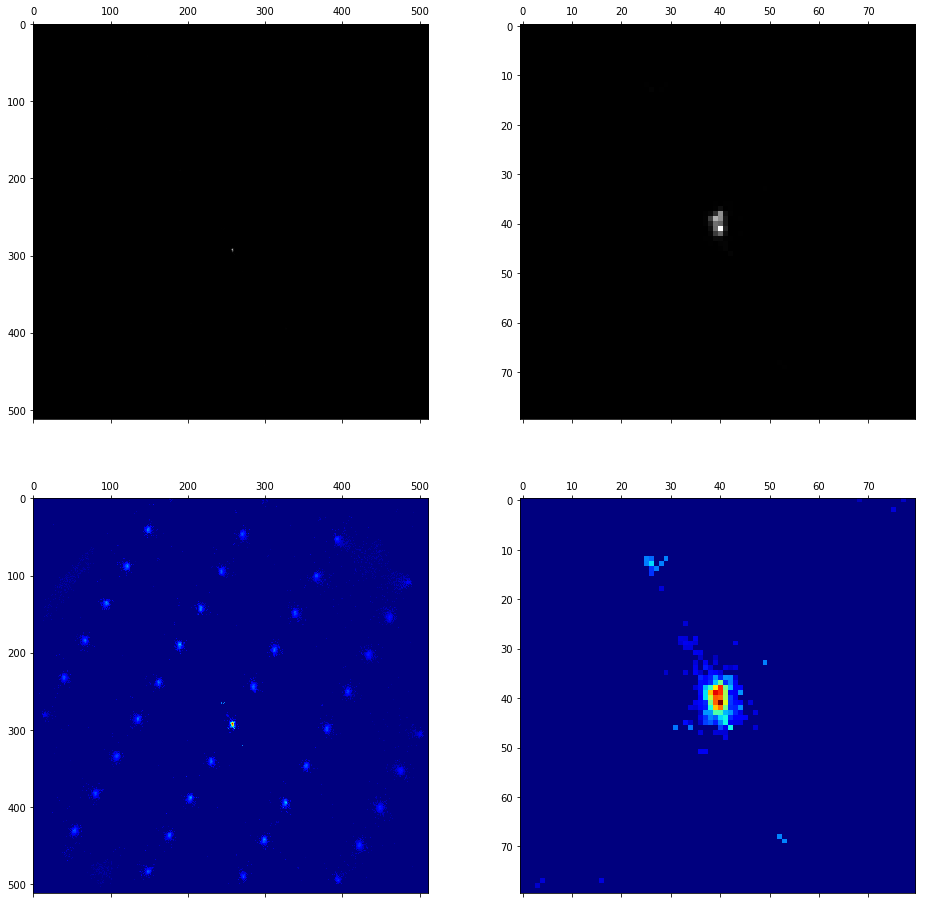

In [16]:
# Plot

x0,y0=np.unravel_index(np.argmax(gaussian_filter(deconvolution.data2D,3)),(dc.Q_Nx,dc.Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(deconvolution.data2D)
ax12.matshow(deconvolution.data2D[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(deconvolution.data2D**0.25,cmap='jet')
ax22.matshow(deconvolution.data2D[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

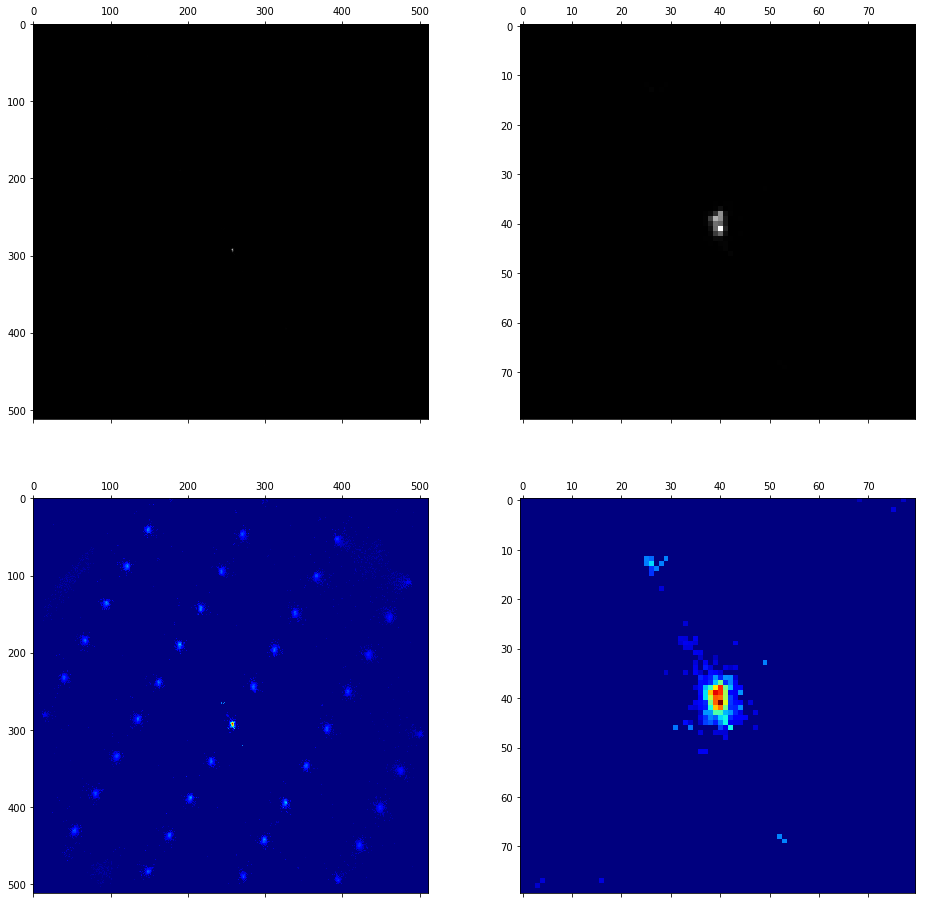

In [17]:
# Plot

x0,y0=np.unravel_index(np.argmax(gaussian_filter(deconvolution.data2D,3)),(dc.Q_Nx,dc.Q_Ny))
x0,y0=int(x0),int(y0)
rad=40

fig,((ax11,ax12),(ax21,ax22))=plt.subplots(2,2,figsize=(16,16))
ax11.matshow(deconvolution.data2D)
ax12.matshow(deconvolution.data2D[x0-rad:x0+rad,y0-rad:y0+rad])
ax21.matshow(deconvolution.data2D**0.25,cmap='jet')
ax22.matshow(deconvolution.data2D[x0-rad:x0+rad,y0-rad:y0+rad]**0.25,cmap='jet')
plt.show()

### Save

In [18]:
# Append to processing file

dataobjects = [diffraction_shifts_fit, shifted_Braggpeak_pointlistarray, deconvolution]

fp = "/home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5"
append(dataobjects, fp)

Opening file /home/ben/Data/20180905_FePO4_unlithiated/processing/Stack1_processing.h5...
Done.


### (Optional) Create shift-corrected 4D datacube

In [20]:
# Apply shifts

data4D_corrected = np.empty_like(dc.data4D,dtype='float32')

t0=time()
for i in range(dc.R_Nx):
    for j in range(dc.R_Ny):
        print("Shifting DP from scan position {},{}".format(i,j))
        data4D_corrected[i,j,:,:] = py4DSTEM.process.utils.get_shifted_ar(dc.data4D[i,j,:,:], 
                                                   -diffraction_shifts_fit.data2D['x'][i,j],
                                                   -diffraction_shifts_fit.data2D['y'][i,j])

t=time()-t0
print("Finished in {}h {}m {}s".format(int(t/3600),int(t/60),int(t%60)))

Shifting DP from scan position 0,0
Shifting DP from scan position 0,1
Shifting DP from scan position 0,2
Shifting DP from scan position 0,3
Shifting DP from scan position 0,4
Shifting DP from scan position 0,5
Shifting DP from scan position 0,6
Shifting DP from scan position 0,7
Shifting DP from scan position 0,8
Shifting DP from scan position 0,9
Shifting DP from scan position 0,10
Shifting DP from scan position 0,11
Shifting DP from scan position 0,12
Shifting DP from scan position 0,13
Shifting DP from scan position 0,14
Shifting DP from scan position 0,15
Shifting DP from scan position 0,16
Shifting DP from scan position 0,17
Shifting DP from scan position 0,18
Shifting DP from scan position 0,19
Shifting DP from scan position 0,20
Shifting DP from scan position 0,21
Shifting DP from scan position 0,22
Shifting DP from scan position 0,23
Shifting DP from scan position 0,24
Shifting DP from scan position 0,25
Shifting DP from scan position 0,26
Shifting DP from scan position 0,27
Sh

Shifting DP from scan position 4,5
Shifting DP from scan position 4,6
Shifting DP from scan position 4,7
Shifting DP from scan position 4,8
Shifting DP from scan position 4,9
Shifting DP from scan position 4,10
Shifting DP from scan position 4,11
Shifting DP from scan position 4,12
Shifting DP from scan position 4,13
Shifting DP from scan position 4,14
Shifting DP from scan position 4,15
Shifting DP from scan position 4,16
Shifting DP from scan position 4,17
Shifting DP from scan position 4,18
Shifting DP from scan position 4,19
Shifting DP from scan position 4,20
Shifting DP from scan position 4,21
Shifting DP from scan position 4,22
Shifting DP from scan position 4,23
Shifting DP from scan position 4,24
Shifting DP from scan position 4,25
Shifting DP from scan position 4,26
Shifting DP from scan position 4,27
Shifting DP from scan position 4,28
Shifting DP from scan position 4,29
Shifting DP from scan position 4,30
Shifting DP from scan position 4,31
Shifting DP from scan position 4,

Shifting DP from scan position 8,11
Shifting DP from scan position 8,12
Shifting DP from scan position 8,13
Shifting DP from scan position 8,14
Shifting DP from scan position 8,15
Shifting DP from scan position 8,16
Shifting DP from scan position 8,17
Shifting DP from scan position 8,18
Shifting DP from scan position 8,19
Shifting DP from scan position 8,20
Shifting DP from scan position 8,21
Shifting DP from scan position 8,22
Shifting DP from scan position 8,23
Shifting DP from scan position 8,24
Shifting DP from scan position 8,25
Shifting DP from scan position 8,26
Shifting DP from scan position 8,27
Shifting DP from scan position 8,28
Shifting DP from scan position 8,29
Shifting DP from scan position 8,30
Shifting DP from scan position 8,31
Shifting DP from scan position 8,32
Shifting DP from scan position 8,33
Shifting DP from scan position 8,34
Shifting DP from scan position 8,35
Shifting DP from scan position 8,36
Shifting DP from scan position 8,37
Shifting DP from scan positi

Shifting DP from scan position 12,10
Shifting DP from scan position 12,11
Shifting DP from scan position 12,12
Shifting DP from scan position 12,13
Shifting DP from scan position 12,14
Shifting DP from scan position 12,15
Shifting DP from scan position 12,16
Shifting DP from scan position 12,17
Shifting DP from scan position 12,18
Shifting DP from scan position 12,19
Shifting DP from scan position 12,20
Shifting DP from scan position 12,21
Shifting DP from scan position 12,22
Shifting DP from scan position 12,23
Shifting DP from scan position 12,24
Shifting DP from scan position 12,25
Shifting DP from scan position 12,26
Shifting DP from scan position 12,27
Shifting DP from scan position 12,28
Shifting DP from scan position 12,29
Shifting DP from scan position 12,30
Shifting DP from scan position 12,31
Shifting DP from scan position 12,32
Shifting DP from scan position 12,33
Shifting DP from scan position 12,34
Shifting DP from scan position 12,35
Shifting DP from scan position 12,36
S

Shifting DP from scan position 16,8
Shifting DP from scan position 16,9
Shifting DP from scan position 16,10
Shifting DP from scan position 16,11
Shifting DP from scan position 16,12
Shifting DP from scan position 16,13
Shifting DP from scan position 16,14
Shifting DP from scan position 16,15
Shifting DP from scan position 16,16
Shifting DP from scan position 16,17
Shifting DP from scan position 16,18
Shifting DP from scan position 16,19
Shifting DP from scan position 16,20
Shifting DP from scan position 16,21
Shifting DP from scan position 16,22
Shifting DP from scan position 16,23
Shifting DP from scan position 16,24
Shifting DP from scan position 16,25
Shifting DP from scan position 16,26
Shifting DP from scan position 16,27
Shifting DP from scan position 16,28
Shifting DP from scan position 16,29
Shifting DP from scan position 16,30
Shifting DP from scan position 16,31
Shifting DP from scan position 16,32
Shifting DP from scan position 16,33
Shifting DP from scan position 16,34
Shi

Shifting DP from scan position 20,8
Shifting DP from scan position 20,9
Shifting DP from scan position 20,10
Shifting DP from scan position 20,11
Shifting DP from scan position 20,12
Shifting DP from scan position 20,13
Shifting DP from scan position 20,14
Shifting DP from scan position 20,15
Shifting DP from scan position 20,16
Shifting DP from scan position 20,17
Shifting DP from scan position 20,18
Shifting DP from scan position 20,19
Shifting DP from scan position 20,20
Shifting DP from scan position 20,21
Shifting DP from scan position 20,22
Shifting DP from scan position 20,23
Shifting DP from scan position 20,24
Shifting DP from scan position 20,25
Shifting DP from scan position 20,26
Shifting DP from scan position 20,27
Shifting DP from scan position 20,28
Shifting DP from scan position 20,29
Shifting DP from scan position 20,30
Shifting DP from scan position 20,31
Shifting DP from scan position 20,32
Shifting DP from scan position 20,33
Shifting DP from scan position 20,34
Shi

Shifting DP from scan position 24,5
Shifting DP from scan position 24,6
Shifting DP from scan position 24,7
Shifting DP from scan position 24,8
Shifting DP from scan position 24,9
Shifting DP from scan position 24,10
Shifting DP from scan position 24,11
Shifting DP from scan position 24,12
Shifting DP from scan position 24,13
Shifting DP from scan position 24,14
Shifting DP from scan position 24,15
Shifting DP from scan position 24,16
Shifting DP from scan position 24,17
Shifting DP from scan position 24,18
Shifting DP from scan position 24,19
Shifting DP from scan position 24,20
Shifting DP from scan position 24,21
Shifting DP from scan position 24,22
Shifting DP from scan position 24,23
Shifting DP from scan position 24,24
Shifting DP from scan position 24,25
Shifting DP from scan position 24,26
Shifting DP from scan position 24,27
Shifting DP from scan position 24,28
Shifting DP from scan position 24,29
Shifting DP from scan position 24,30
Shifting DP from scan position 24,31
Shifti

Shifting DP from scan position 28,9
Shifting DP from scan position 28,10
Shifting DP from scan position 28,11
Shifting DP from scan position 28,12
Shifting DP from scan position 28,13
Shifting DP from scan position 28,14
Shifting DP from scan position 28,15
Shifting DP from scan position 28,16
Shifting DP from scan position 28,17
Shifting DP from scan position 28,18
Shifting DP from scan position 28,19
Shifting DP from scan position 28,20
Shifting DP from scan position 28,21
Shifting DP from scan position 28,22
Shifting DP from scan position 28,23
Shifting DP from scan position 28,24
Shifting DP from scan position 28,25
Shifting DP from scan position 28,26
Shifting DP from scan position 28,27
Shifting DP from scan position 28,28
Shifting DP from scan position 28,29
Shifting DP from scan position 28,30
Shifting DP from scan position 28,31
Shifting DP from scan position 28,32
Shifting DP from scan position 28,33
Shifting DP from scan position 28,34
Shifting DP from scan position 28,35
Sh

Shifting DP from scan position 32,9
Shifting DP from scan position 32,10
Shifting DP from scan position 32,11
Shifting DP from scan position 32,12
Shifting DP from scan position 32,13
Shifting DP from scan position 32,14
Shifting DP from scan position 32,15
Shifting DP from scan position 32,16
Shifting DP from scan position 32,17
Shifting DP from scan position 32,18
Shifting DP from scan position 32,19
Shifting DP from scan position 32,20
Shifting DP from scan position 32,21
Shifting DP from scan position 32,22
Shifting DP from scan position 32,23
Shifting DP from scan position 32,24
Shifting DP from scan position 32,25
Shifting DP from scan position 32,26
Shifting DP from scan position 32,27
Shifting DP from scan position 32,28
Shifting DP from scan position 32,29
Shifting DP from scan position 32,30
Shifting DP from scan position 32,31
Shifting DP from scan position 32,32
Shifting DP from scan position 32,33
Shifting DP from scan position 32,34
Shifting DP from scan position 32,35
Sh

Shifting DP from scan position 36,9
Shifting DP from scan position 36,10
Shifting DP from scan position 36,11
Shifting DP from scan position 36,12
Shifting DP from scan position 36,13
Shifting DP from scan position 36,14
Shifting DP from scan position 36,15
Shifting DP from scan position 36,16
Shifting DP from scan position 36,17
Shifting DP from scan position 36,18
Shifting DP from scan position 36,19
Shifting DP from scan position 36,20
Shifting DP from scan position 36,21
Shifting DP from scan position 36,22
Shifting DP from scan position 36,23
Shifting DP from scan position 36,24
Shifting DP from scan position 36,25
Shifting DP from scan position 36,26
Shifting DP from scan position 36,27
Shifting DP from scan position 36,28
Shifting DP from scan position 36,29
Shifting DP from scan position 36,30
Shifting DP from scan position 36,31
Shifting DP from scan position 36,32
Shifting DP from scan position 36,33
Shifting DP from scan position 36,34
Shifting DP from scan position 36,35
Sh

Shifting DP from scan position 40,13
Shifting DP from scan position 40,14
Shifting DP from scan position 40,15
Shifting DP from scan position 40,16
Shifting DP from scan position 40,17
Shifting DP from scan position 40,18
Shifting DP from scan position 40,19
Shifting DP from scan position 40,20
Shifting DP from scan position 40,21
Shifting DP from scan position 40,22
Shifting DP from scan position 40,23
Shifting DP from scan position 40,24
Shifting DP from scan position 40,25
Shifting DP from scan position 40,26
Shifting DP from scan position 40,27
Shifting DP from scan position 40,28
Shifting DP from scan position 40,29
Shifting DP from scan position 40,30
Shifting DP from scan position 40,31
Shifting DP from scan position 40,32
Shifting DP from scan position 40,33
Shifting DP from scan position 40,34
Shifting DP from scan position 40,35
Shifting DP from scan position 40,36
Shifting DP from scan position 40,37
Shifting DP from scan position 40,38
Shifting DP from scan position 40,39
S

Shifting DP from scan position 44,9
Shifting DP from scan position 44,10
Shifting DP from scan position 44,11
Shifting DP from scan position 44,12
Shifting DP from scan position 44,13
Shifting DP from scan position 44,14
Shifting DP from scan position 44,15
Shifting DP from scan position 44,16
Shifting DP from scan position 44,17
Shifting DP from scan position 44,18
Shifting DP from scan position 44,19
Shifting DP from scan position 44,20
Shifting DP from scan position 44,21
Shifting DP from scan position 44,22
Shifting DP from scan position 44,23
Shifting DP from scan position 44,24
Shifting DP from scan position 44,25
Shifting DP from scan position 44,26
Shifting DP from scan position 44,27
Shifting DP from scan position 44,28
Shifting DP from scan position 44,29
Shifting DP from scan position 44,30
Shifting DP from scan position 44,31
Shifting DP from scan position 44,32
Shifting DP from scan position 44,33
Shifting DP from scan position 44,34
Shifting DP from scan position 44,35
Sh

In [19]:
# Store new, shifted datacube
datacube_shifted = py4DSTEM.process.datastructure.DataCube(data=data4D_corrected,
                                                           parentDataCube=dc, 
                                                           name="shift_corrected_datacube")

In [ ]:
# # Save shift corrected 4D datacube
# savepath = "/Users/Ben/Work/NCEM/Projects/py4DSTEM/sample_data/20180905_FePO4_unlithiated/processing/shift_corrected_datacube.h5"
# py4DSTEM.readwrite.save_datacube(datacube_shifted,savepath)

In [22]:
# Save shift corrected 4D datacube
savepath = "/home/ben/Data/20180905_FePO4_unlithiated/h5/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4__shiftcorrected.h5"
py4DSTEM.readwrite.save_datacube(dc,savepath)

Creating file /home/ben/Data/20180905_FePO4_unlithiated/h5/Stack2_60x60+30nmss_spot 8_0p05s_CL=600_alpha=0p48_300kV_bin4__shiftcorrected.h5...
Writing metadata...
Done.
